In [3]:
####################################


#THIS FIRST SECTION WILL IMPORT THE TRAINING DATA AND SETUP THE INFORMATION FOR TRAINING


####################################

In [4]:
#import libraries you used 
import os
import pandas as pd
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tarfile
from PIL import Image
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision import transforms
import shutil
from sklearn.metrics import f1_score
from torch.utils.data.dataloader import DataLoader


## Import the data into the document
image_dir = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]


## CREATE A FILE WITH THE DESIRED IMAGES ONLY

# Define the classifications to filter and their numeric mappings
classification_mapping = {
    "Embraer E-Jet": 0,
    "Boeing 737": 1,
    "A320": 2,
    "Cessna Citation": 3,
    "Gulfstream": 4
}

# Define the file path
file_path = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_family_train.txt'
# Read the file and handle inconsistent line structures
data = []
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        parts = line.strip().split()
        if len(parts) >= 2:  # Ensure at least two fields exist
            number = parts[0]
            classification = ' '.join(parts[1:])  # Combine remaining parts
            data.append({"Number": number, "Classification": classification})
        else:
            print(f"Skipping invalid line {i + 1}: {line.strip()}")  # Debugging invalid lines

# Convert to a DataFrame
df = pd.DataFrame(data)

# Standardise the Classification column
df['Classification'] = df['Classification'].str.strip()  # Remove extra spaces
df['Classification'] = df['Classification'].str.title()  # Standardise capitalisation

# Add numeric labels and filter invalid classifications
df['Label'] = df['Classification'].map(classification_mapping)
df = df.dropna(subset=['Label']).reset_index(drop=True)  # Remove rows with invalid classifications

# Display the resulting DataFrame
print(df)

from collections import Counter

# Read the file and collect classifications
classifications = []
with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) >= 2:  # Ensure there are at least two fields
            classification = ' '.join(parts[1:]).strip()  # Combine fields after the first
            classifications.append(classification)

# Count the occurrences of each classification
classification_counts = Counter(classifications)

# Display the results
print("Classification Counts:")
for classification, count in classification_counts.items():
    print(f"{classification}: {count}")

# Count the occurrences of each classification in the filtered DataFrame
filtered_classification_counts = df['Classification'].value_counts()

# Display the results
print("Filtered Classification Counts:")
print(filtered_classification_counts)


## Create a folder with only the photos to keep

# Path to your folder containing images
image_folder_path = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'

relevant_codes = set(df['Number'])  # Convert to a set for faster lookup

# Initialize a list to hold image tensors
image_tensors = []

# Define the image transformation (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to a fixed size (e.g., 224x224)
    transforms.ToTensor()  # Convert image to PyTorch tensor
])

# Iterate over files in the folder
for image_file in os.listdir(image_folder_path):
    # Extract the numeric part of the file name (assuming it's the code)
    code = os.path.splitext(image_file)[0]
    if code in relevant_codes and image_file.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(image_folder_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Ensure 3 color channels (RGB)
        
        # Transform the image and append to the list
        tensor = transform(img)
        image_tensors.append(tensor)
        print(f"Loaded and transformed: {image_file}")

# Stack all tensors into a single tensor
if image_tensors:
    image_tensor_batch = torch.stack(image_tensors)
    print(f"Created a tensor of shape: {image_tensor_batch.shape}")
else:
    print("No images matched the criteria!")

# Example tensor shape: [num_images, channels, height, width]

      Number Classification  Label
0    0822348     Boeing 737    1.0
1    1152739     Boeing 737    1.0
2    0907429     Boeing 737    1.0
3    0209554     Boeing 737    1.0
4    1187709     Boeing 737    1.0
..       ...            ...    ...
628  1857543     Gulfstream    4.0
629  0517785     Gulfstream    4.0
630  1311419     Gulfstream    4.0
631  2106202     Gulfstream    4.0
632  0497885     Gulfstream    4.0

[633 rows x 3 columns]
Classification Counts:
Boeing 707: 34
Boeing 727: 33
Boeing 737: 267
Boeing 747: 133
Boeing 757: 67
Boeing 767: 100
Boeing 777: 66
A300: 34
A310: 33
A320: 133
A330: 67
A340: 133
A380: 34
ATR-42: 33
ATR-72: 33
An-12: 34
BAE 146: 66
BAE-125: 34
Beechcraft 1900: 33
Boeing 717: 33
C-130: 34
C-47: 33
CRJ-200: 33
CRJ-700: 67
Cessna 172: 33
Cessna 208: 34
Cessna Citation: 66
Challenger 600: 34
DC-10: 33
DC-3: 33
DC-6: 34
DC-8: 33
DC-9: 33
DH-82: 34
DHC-1: 33
DHC-6: 33
Dash 8: 67
DR-400: 33
Dornier 328: 34
Embraer E-Jet: 100
EMB-120: 33
Embraer ERJ 145: 67
E

In [5]:
####################################


#THIS SECOND SECTION WILL IMPORT THE TESTING DATA AND SETUP THE INFORMATION FOR F1 TESTING


####################################

In [6]:
# File path for the testing data classification file
test_file_path = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_family_test.txt'

# Read and process the testing data file
test_data = []
with open(test_file_path, 'r') as file:
    for i, line in enumerate(file):
        parts = line.strip().split()
        if len(parts) >= 2:  # Ensure there are at least two fields
            number = parts[0]
            classification = ' '.join(parts[1:])  # Combine remaining parts
            test_data.append({"Number": number, "Classification": classification})
        else:
            print(f"Skipping invalid line {i + 1}: {line.strip()}")  # Debugging invalid lines

# Convert to a DataFrame
df_test = pd.DataFrame(test_data)

# Standardise the Classification column
df_test['Classification'] = df_test['Classification'].str.strip()  # Remove extra spaces
df_test['Classification'] = df_test['Classification'].str.title()  # Standardise capitalisation

# Add numeric labels and filter invalid classifications
df_test['Label'] = df_test['Classification'].map(classification_mapping)
df_test = df_test.dropna(subset=['Label']).reset_index(drop=True)  # Remove rows with invalid classifications

# Display the resulting DataFrame
print(df_test)

# Path to the testing images
test_image_folder_path = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'

# Relevant test image codes
relevant_test_codes = set(df_test['Number'])  # Convert to a set for faster lookup

# Initialize a list to hold testing image tensors
test_image_tensors = []

# Define the image transformation (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to a fixed size (e.g., 224x224)
    transforms.ToTensor()  # Convert image to PyTorch tensor
])

# Iterate over files in the folder
for image_file in os.listdir(test_image_folder_path):
    # Extract the numeric part of the file name (assuming it's the code)
    code = os.path.splitext(image_file)[0]
    if code in relevant_test_codes and image_file.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(test_image_folder_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Ensure 3 color channels (RGB)
        
        # Transform the image and append to the list
        tensor = transform(img)
        test_image_tensors.append(tensor)
        print(f"Loaded and transformed: {image_file}")

# Stack all tensors into a single tensor
if test_image_tensors:
    test_image_tensor_batch = torch.stack(test_image_tensors)
    print(f"Created a testing tensor of shape: {test_image_tensor_batch.shape}")
else:
    print("No testing images matched the criteria!")

# Example tensor shape: [num_test_images, channels, height, width]


      Number Classification  Label
0    0227058     Boeing 737    1.0
1    0950275     Boeing 737    1.0
2    0114122     Boeing 737    1.0
3    1754503     Boeing 737    1.0
4    0127648     Boeing 737    1.0
..       ...            ...    ...
630  0447762     Gulfstream    4.0
631  0396507     Gulfstream    4.0
632  2030079     Gulfstream    4.0
633  1063148     Gulfstream    4.0
634  0492487     Gulfstream    4.0

[635 rows x 3 columns]
Loaded and transformed: 2221342.jpg
Loaded and transformed: 1548400.jpg
Loaded and transformed: 1107447.jpg
Loaded and transformed: 1476061.jpg
Loaded and transformed: 2227525.jpg
Loaded and transformed: 1259554.jpg
Loaded and transformed: 1698699.jpg
Loaded and transformed: 0218033.jpg
Loaded and transformed: 1142906.jpg
Loaded and transformed: 1510253.jpg
Loaded and transformed: 1119094.jpg
Loaded and transformed: 1398526.jpg
Loaded and transformed: 1768807.jpg
Loaded and transformed: 1508811.jpg
Loaded and transformed: 2002331.jpg
Loaded and trans

In [7]:
####################################


#THIS 3rd SECTION WILL SETUP AND TRAIN THE NEURAL NETWORK

####################################

CourseworkCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=28, bias=True)
)
Epoch [1/50], Train Loss: 25.7260, Test Loss: 18.6030, Train Acc: 0.2543, Test Acc: 0.1323, F1 Score

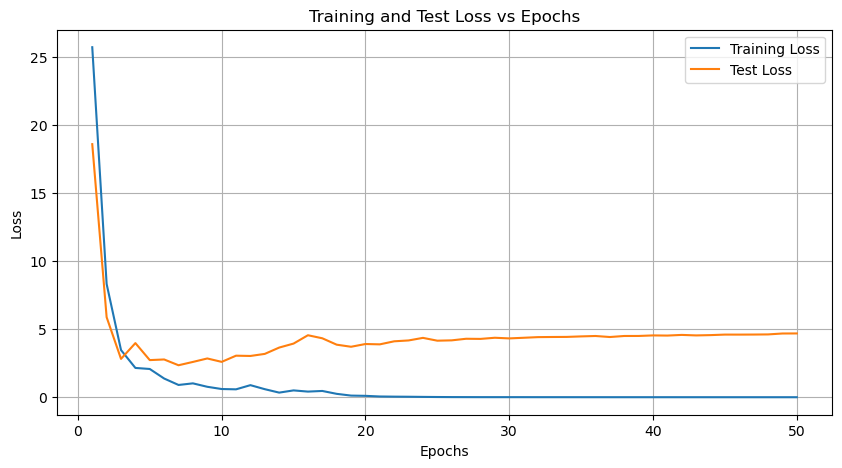

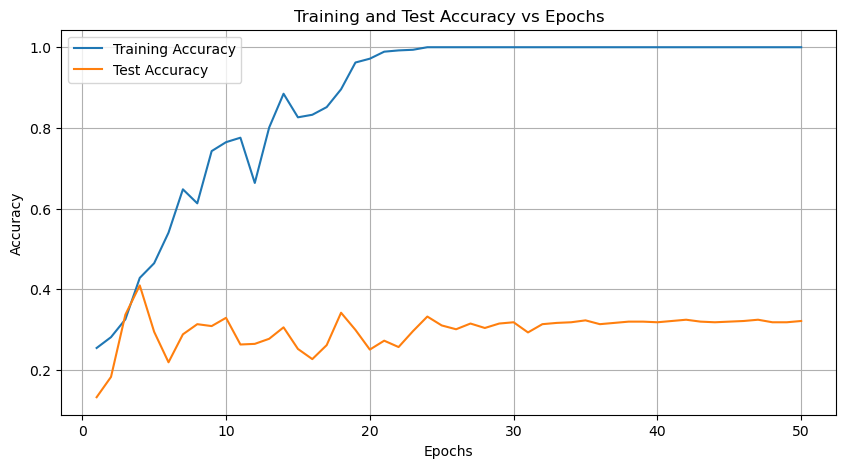

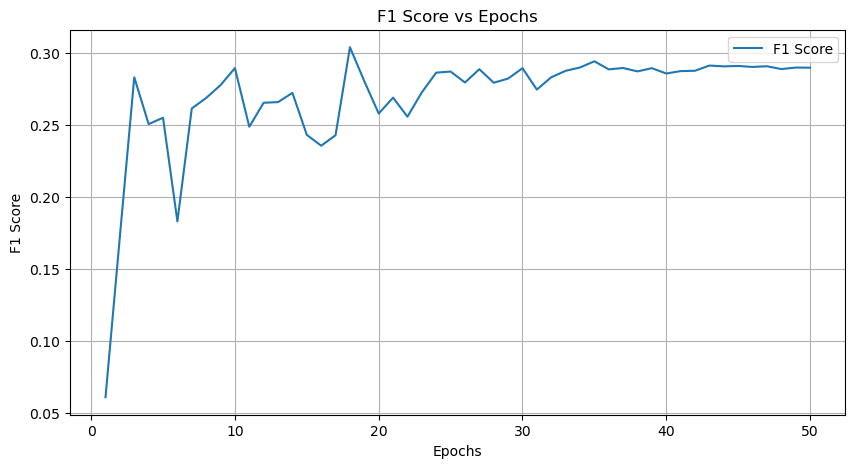

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

train_dataset = TensorDataset(
    image_tensor_batch, 
    torch.tensor(df['Label'].values, dtype=torch.long)  # Ensure labels are torch.long
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Ensure test_image_tensor_batch and df_test['Label'] are defined
test_dataset = TensorDataset(
    test_image_tensor_batch, 
    torch.tensor(df_test['Label'].values, dtype=torch.long)  # Ensure labels are torch.long
)

# Create DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CourseworkCNN(nn.Module):
    def __init__(self, num_classes=5):  # Adapt to the number of classes in your dataset
        super(CourseworkCNN, self).__init__()
        
         # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block (optional deeper network)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Adjust based on image size after convolutions
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Instantiate the CNN model
coursework_cnn = CourseworkCNN(num_classes=28)
print(coursework_cnn)

# Define the loss function and optimizer for the CourseworkCNN
criterion = nn.CrossEntropyLoss()

import torch.optim as optim

# Define your optimizer
optimizer = optim.Adam(coursework_cnn.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop for CourseworkCNN
epochs = 50
metrics = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "f1_score": []
}

coursework_cnn.train()  # Set model to training mode
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:  # Use train_loader for training data
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = coursework_cnn(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train

    # Evaluate on test set
    coursework_cnn.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_true_labels = []
    all_predicted_labels = []
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:  # Use test_loader for testing data
            outputs = coursework_cnn(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Get predictions
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(preds.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}")

    metrics["train_loss"].append(running_loss / len(train_loader))
    metrics["test_loss"].append(test_loss / len(test_loader))
    metrics["train_acc"].append(train_accuracy)
    metrics["test_acc"].append(test_accuracy)
    metrics["f1_score"].append(f1)

    coursework_cnn.train()  # Set model back to training mode after evaluation

# Metrics stored in 'metrics' dictionary for further analysis

# Plotting results
num_epochs = epochs
train_losses = metrics["train_loss"]
test_losses = metrics["test_loss"]
train_accuracies = metrics["train_acc"]
test_accuracies = metrics["test_acc"]
f1_scores = metrics["f1_score"]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
